In [ ]:
import os
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
DATASET_PATH = r"F:\TG MINTA\maestro-v3.0.0\maestro-v3.0.0"
SAVE_PATH = r"F:\TG MINTA\maestro-v3.0.0\extraccion_datos"
FRAME_RATE = 100
NOTE_RANGE = (21, 109)
SEQUENCE_LENGTH = 50
WINDOW_SIZE = 32

In [ ]:
X_path = Path(SAVE_PATH) / "X_all.npy"
Y_path = Path(SAVE_PATH) / "Y_all.npy"

if X_path.exists() and Y_path.exists():
    print("Cargando archivos desde disco con mmap_mode")
    X_all = np.load(X_path, mmap_mode='r')
    Y_all = np.load(Y_path, mmap_mode='r')
else:
    print("Procesando archivos por primera vez")
    dataset_path = Path(DATASET_PATH)
    SAVE_PATH.mkdir(parents=True, exist_ok=True)

    wav_files = sorted(dataset_path.rglob("*.wav"))
    midi_files = sorted([f for f in dataset_path.rglob("*") if f.suffix.lower() in [".mid", ".midi"]])
    midi_dict = {f.stem: f for f in midi_files}
    paired_files = [(wav, midi_dict[wav.stem]) for wav in wav_files if wav.stem in midi_dict]

    X_data, Y_data = [], []
    processed_count = 0

    for wav_path, midi_path in paired_files:
        try:
            y, sr = librosa.load(wav_path, sr=None)
            hop = int(sr / FRAME_RATE)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop).T
            piano_roll = midi_to_piano_roll(midi_path, len(mfcc), sr, hop)
            min_len = min(mfcc.shape[0], piano_roll.shape[0])
            X_data.append(mfcc[:min_len])
            Y_data.append(piano_roll[:min_len])
            processed_count += 1
        except Exception as e:
            print(f"Error con archivo {wav_path.name}: {e}")

    X_all = np.concatenate(X_data)
    Y_all = np.concatenate(Y_data)
    np.save(X_path, X_all)
    np.save(Y_path, Y_all)
    
    print("Datos guardados")
    print(f"ARCHIVOS (PARES) PROCESADOS: {processed_count}")

    X_all = np.load(X_path, mmap_mode='r')
    Y_all = np.load(Y_path, mmap_mode='r')
    
print("Forma de X:", X_all.shape)
print("Forma de Y:", Y_all.shape)
print(f"Tipo de X_all: {type(X_all)}")
print(f"Tipo de Y_all: {type(Y_all)}")


Cargando archivos desde disco con mmap_mode...
Forma de X: (70851235, 20)
Forma de Y: (70851235, 88)
Tipo de X_all: <class 'numpy.memmap'>
Tipo de Y_all: <class 'numpy.memmap'>


In [13]:

print("SVM")
X_svm = X_all[:10000]
Y_svm = Y_all[:10000]
svm_model = make_pipeline(StandardScaler(), OneVsRestClassifier(SVC(kernel='rbf', probability=True)))
svm_model.fit(X_svm, Y_svm)
Y_pred_svm = svm_model.predict(X_svm)
f1_svm = f1_score(Y_svm.flatten(), Y_pred_svm.flatten())
print(f"F1-score SVM: {f1_svm:.4f}")


SVM


c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
c:\Users\Goliath\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py:90:

F1-score SVM: 0.7112


In [14]:

print("RNN.")
def create_sequences(X, Y, seq_len):
    X_seq, Y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        Y_seq.append(Y[i])
    return np.array(X_seq), np.array(Y_seq)

X_rnn, Y_rnn = create_sequences(X_all[:200000], Y_all[:200000], SEQUENCE_LENGTH)
X_train_rnn, X_test_rnn, Y_train_rnn, Y_test_rnn = train_test_split(X_rnn, Y_rnn, test_size=0.2)

model_rnn = models.Sequential([
    layers.Input(shape=(SEQUENCE_LENGTH, 20)),
    layers.LSTM(128),
    layers.Dense(88, activation='sigmoid')
])
model_rnn.compile(optimizer='adam', loss='binary_crossentropy')
model_rnn.fit(X_train_rnn, Y_train_rnn, epochs=30, batch_size=128, validation_split=0.1)
Y_pred_rnn = (model_rnn.predict(X_test_rnn) > 0.5).astype(int)
f1_rnn = f1_score(Y_test_rnn.flatten(), Y_pred_rnn.flatten())
print(f"F1-score RNN: {f1_rnn:.4f}")


RNN.
Epoch 1/30
1125/1125 [==============================] - 54s 47ms/step - loss: 0.1707 - val_loss: 0.1520
Epoch 2/30
1125/1125 [==============================] - 58s 52ms/step - loss: 0.1465 - val_loss: 0.1445
Epoch 3/30
1125/1125 [==============================] - 60s 54ms/step - loss: 0.1407 - val_loss: 0.1398
Epoch 4/30
1125/1125 [==============================] - 60s 54ms/step - loss: 0.1368 - val_loss: 0.1367
Epoch 5/30
1125/1125 [==============================] - 58s 51ms/step - loss: 0.1336 - val_loss: 0.1335
Epoch 6/30
1125/1125 [==============================] - 58s 52ms/step - loss: 0.1312 - val_loss: 0.1317
Epoch 7/30
1125/1125 [==============================] - 61s 54ms/step - loss: 0.1295 - val_loss: 0.1300
Epoch 8/30
1125/1125 [==============================] - 59s 53ms/step - loss: 0.1281 - val_loss: 0.1292
Epoch 9/30
1125/1125 [==============================] - 59s 53ms/step - loss: 0.1269 - val_loss: 0.1279
Epoch 10/30
1125/1125 [==============================] - 60

In [15]:

print("CNN")
X_cnn, Y_cnn = [], []
for i in range(WINDOW_SIZE, min(len(X_all), 100000 + WINDOW_SIZE)):
    window = X_all[i - WINDOW_SIZE:i].T
    X_cnn.append(window[..., np.newaxis])
    Y_cnn.append(Y_all[i])
X_cnn = np.array(X_cnn)
Y_cnn = np.array(Y_cnn)

mean = np.mean(X_cnn)
std = np.std(X_cnn)
X_cnn = (X_cnn - mean) / std

X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X_cnn, Y_cnn, test_size=0.2)

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_cnn.shape[1:]),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(88, activation='sigmoid')  # For multi-label classification
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_cnn.fit(X_train_cnn, Y_train_cnn, epochs=100, batch_size=128, validation_split=0.1, callbacks=[early_stop])
Y_pred_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype(int)
f1_cnn = f1_score(Y_test_cnn.flatten(), Y_pred_cnn.flatten())
print(f"F1-score CNN: {f1_cnn:.4f}")


CNN
Epoch 1/100
563/563 [==============================] - 12s 20ms/step - loss: 0.1059 - val_loss: 0.0832
Epoch 2/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0843 - val_loss: 0.0756
Epoch 3/100
563/563 [==============================] - 11s 20ms/step - loss: 0.0797 - val_loss: 0.0725
Epoch 4/100
563/563 [==============================] - 11s 20ms/step - loss: 0.0765 - val_loss: 0.0679
Epoch 5/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0739 - val_loss: 0.0645
Epoch 6/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0721 - val_loss: 0.0623
Epoch 7/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0703 - val_loss: 0.0599
Epoch 8/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0685 - val_loss: 0.0578
Epoch 9/100
563/563 [==============================] - 11s 19ms/step - loss: 0.0673 - val_loss: 0.0564
Epoch 10/100
563/563 [==============================] - 11s 20ms/step

625/625 [==============================] - 1s 2ms/step


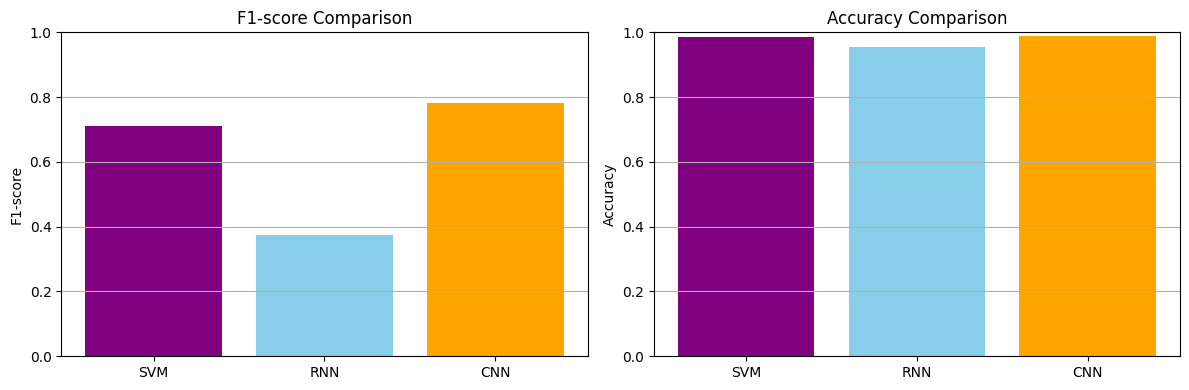

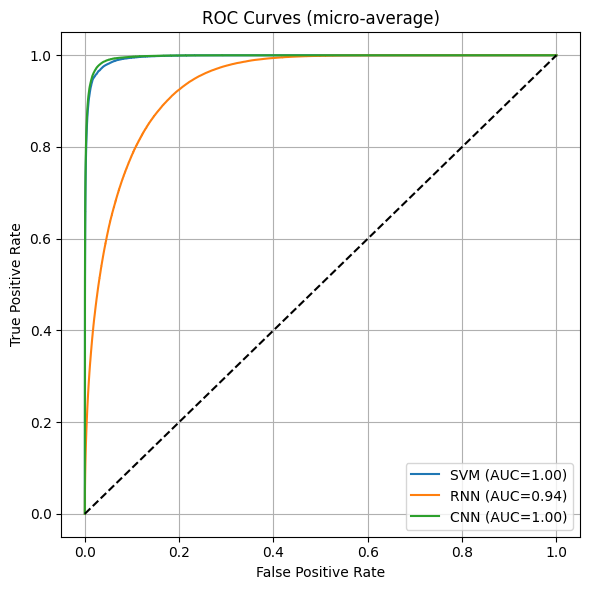

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# Probabilidades / scores
Y_prob_svm = svm_model.predict_proba(X_svm)
Y_prob_rnn = model_rnn.predict(X_test_rnn)
Y_prob_cnn = model_cnn.predict(X_test_cnn)

# Verdaderos y predichos
y_true_svm = Y_svm.flatten();     y_pred_svm = Y_pred_svm.flatten()
y_true_rnn = Y_test_rnn.flatten();y_pred_rnn = Y_pred_rnn.flatten()
y_true_cnn = Y_test_cnn.flatten();y_pred_cnn = Y_pred_cnn.flatten()

# Accuracy
acc_svm = accuracy_score(y_true_svm, y_pred_svm)
acc_rnn = accuracy_score(y_true_rnn, y_pred_rnn)
acc_cnn = accuracy_score(y_true_cnn, y_pred_cnn)

# ROC curve + AUC (micro-average, flatten)
fpr_svm, tpr_svm, _ = roc_curve(y_true_svm, Y_prob_svm.flatten())
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rnn, tpr_rnn, _ = roc_curve(y_true_rnn, Y_prob_rnn.flatten())
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, Y_prob_cnn.flatten())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# comparativas
models = ['SVM','RNN','CNN']
f1_scores  = [f1_svm,  f1_rnn,  f1_cnn]
acc_scores = [acc_svm, acc_rnn, acc_cnn]



plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(models, f1_scores,  color=['purple','skyblue','orange'])
plt.ylim(0,1)
plt.title('F1-score Comparison')
plt.ylabel('F1-score')
plt.grid(axis='y')

plt.subplot(1,2,2)
plt.bar(models, acc_scores, color=['purple','skyblue','orange'])
plt.ylim(0,1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# 2) ROC Curves (micro-average)
plt.figure(figsize=(6,6))

plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_svm:.2f})")
plt.plot(fpr_rnn, tpr_rnn, label=f"RNN (AUC={roc_auc_rnn:.2f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC={roc_auc_cnn:.2f})")
plt.plot([0,1],[0,1],'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (micro-average)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
